In [377]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML
ins = BrainSpan()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load Data

In [103]:
# Columns Meta Data
bp_exon_col_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv", delimiter=",")
bp_exon_col_meta.age.unique()
bp_exon_col_meta["Period"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
bp_exon_col_meta["Stage"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
bp_exon_col_meta["Description"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)
#print bp_exon_col_meta.shape
display(bp_exon_col_meta.head(2)) 
#print "Sample size", pd.unique(bp_exon_col_meta.donor_id).size
#print "Periods:",bp_exon_col_meta.drop_duplicates("donor_id").groupby("Period")["Period"].count()
strcture_count = bp_exon_col_meta.groupby("structure_acronym")["structure_acronym"].count()
Regions = bp_exon_col_meta.drop_duplicates("structure_acronym")[["structure_id","structure_acronym","structure_name"]]
Regions["sample count"] = Regions.apply(lambda row: strcture_count[row["structure_acronym"]], axis=1)
Regions.to_excel("../data/expression/brainspan/exons_matrix/Regions.xlsx", index=False)
# Rows Meta Data
bp_exon_row_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
display(bp_exon_row_meta.head(2))
# Exon RPKM Matrix
ExonExp = pd.read_csv("../data/expression/brainspan/exons_matrix/expression_matrix.csv", header=None)
display(ExonExp.head(2))
GeneExp = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/expression_matrix.csv", header=None)
GeneRow = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/rows_metadata.csv")
GeneCol = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/columns_metadata.csv")
GeneCol["Period"] = GeneCol.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
GeneCol["Stage"] = GeneCol.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
GeneCol["Description"] = GeneCol.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)
GeneDat = [GeneExp, GeneRow, GeneCol]

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name,Period,Stage,Description
0,1,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip,2A,2,Early prenatal
1,2,13058,H376.IIA.51,8 pcw,M,10194,OFC,orbital frontal cortex,2A,2,Early prenatal


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108


,0,1,2,3,4,5,6,7,8,9,...,515,516,517,518,519,520,521,522,523,524
0,1,13.636583,40.862901,32.178981,27.939465,29.324584,23.885710,24.887880,16.432391,45.570680,...,4.347437,4.101772,2.987192,3.862508,3.362597,2.566516,3.049593,5.025746,1.893471,8.942586
1,2,31.731240,86.587706,60.131360,57.718046,58.326412,54.090394,50.138146,35.408905,94.937737,...,6.332389,5.479924,5.946744,6.017439,5.585987,3.870925,4.083335,7.451925,2.946266,3.868906


In [671]:
def loaddict():
    res = {}
    fin = open("/Users/jiayao/Work/BrainDisorders/src/cds.dict", 'rb')
    for l in fin:
        llist = l.strip().split()
        gene, exon_s, cds_s, cds_e = llist[0], int(llist[1])-1, int(llist[2])-1, int(llist[3])
        if gene not in res:
            res[gene] = {}
        if exon_s not in res[gene]:
            res[gene][exon_s] = (cds_s, cds_e)
    return res
cds_dict = loaddict()

In [672]:
print cds_dict["UBE2Q1"]

{154523872: (154523872, 154523968), 154525507: (154525507, 154525648), 154525211: (154525211, 154525296), 154527210: (154527210, 154527261), 154524396: (154524396, 154524455), 154530702: (154530702, 154531029), 154524879: (154524879, 154524940), 154523413: (154523413, 154523480), 154524246: (154524246, 154524295), 154524568: (154524568, 154524659), 154528335: (154528335, 154528440), 154521052: (154522916, 154522945), 154527903: (154527903, 154528008)}


In [675]:
def addcds(row, cds_dict):
    s = row["start"]
    gene = row["gene_symbol"]
    if gene not in cds_dict:
        return row["exon length"]
    if s in cds_dict[gene]:
        cds_s, cds_e = cds_dict[gene][s]
        return cds_e - cds_s
    else:
        return row["exon length"]

In [676]:
bp_exon_row_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
bp_exon_row_meta["cds length"] = bp_exon_row_meta.apply(lambda row: addcds(row, cds_dict), axis=1)

In [677]:
bp_exon_row_meta.head(5)

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317,1317
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108,66
2,3,1086864,ENSG00000000003,TSPAN6,7105.0,99887481,99887565,84,84
3,4,1086864,ENSG00000000003,TSPAN6,7105.0,99888401,99888536,135,135
4,5,1086864,ENSG00000000003,TSPAN6,7105.0,99888927,99889026,99,99


In [104]:
Regionsgt20 = ['OFC', 'VFC', 'HIP', 'ITC', 'AMY', 'DFC', 'STC', 'MFC', 'STR', 'IPC', 
            'V1C', 'S1C', 'A1C', 'M1C', 'CBC', 'MD']
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]

In [105]:
bp_exon_col_meta[(bp_exon_col_meta["Period"]=="2A") & (bp_exon_col_meta["structure_acronym"].isin(Regionsgt20))]["column_num"].values

array([ 2,  5,  9, 12, 13, 14, 15, 16, 18, 22, 24, 27, 28])

# 2.1 Proband LGD

In [106]:
VarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014LGD.xlsx"
bp_exon_row_meta_wiglerLGD = ins.AssignVar2Exon3(bp_exon_row_meta, VarFile)

309222

In [107]:
bp_exon_row_meta_with_gene = bp_exon_row_meta_wiglerLGD[bp_exon_row_meta_wiglerLGD["GeneHited"]=="T"]
bp_exon_row_meta_with_gene.to_excel("GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape
bp_exon_row_meta_with_var = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["Vars"]!=""]
bp_exon_row_meta_without_var = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["Vars"]==""]
print bp_exon_row_meta_with_gene.shape, bp_exon_row_meta_with_var.shape, bp_exon_row_meta_without_var.shape

(94, 14)
(2269, 15) (118, 15) (2151, 15)


In [108]:
Genes = list(set(bp_exon_row_meta_with_gene["gene_symbol"].values))
ins.LoadGeneSetData2Fil("ProbandLGD.Regionsgt20.GeneExonLog2Exp.csv", 
                        Genes, Regionsgt20, bp_exon_row_meta_with_gene, bp_exon_col_meta, ExonExp)

Total Num of Genes: 94
Load 12 genes

In [708]:
VarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014LGD.xlsx"
bp_exon_row_meta_wiglerLGD = ins.AssignVar2Exon3(bp_exon_row_meta, VarFile, IntersectionWithPredicted=True)

309222

In [709]:
bp_exon_row_meta_with_gene = bp_exon_row_meta_wiglerLGD[bp_exon_row_meta_wiglerLGD["GeneHited"]=="T"]
bp_exon_row_meta_with_gene.to_excel("GenesExonsTargetedByLGD_all.xlsx", index=False)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape
bp_exon_row_meta_with_var = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["Vars"]!=""]
bp_exon_row_meta_without_var = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["Vars"]==""]
print bp_exon_row_meta_with_gene.shape, bp_exon_row_meta_with_var.shape, bp_exon_row_meta_without_var.shape

(94, 15)
(2269, 16) (118, 16) (2151, 16)


In [700]:
Genes = list(set(bp_exon_row_meta_with_gene["gene_symbol"].values))
ins.LoadGeneSetData2Fil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv", 
                        Genes, Regionsgt20, bp_exon_row_meta_with_gene, bp_exon_col_meta, ExonExp)

Total Num of Genes: 340


In [701]:
expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")

In [702]:
Genes = list(set(bp_exon_row_meta_with_gene["gene_symbol"].values))
probandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    probandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(probandLGD.genes), len(probandLGD.TargetedExon),len(probandLGD.UntargetedExon)

340 367 7053


proband LGD - all 11.5672473673 7.67644621301 3.8908011543
proband LGD - predicted 22.6609982479 11.6274311632 11.0335670848


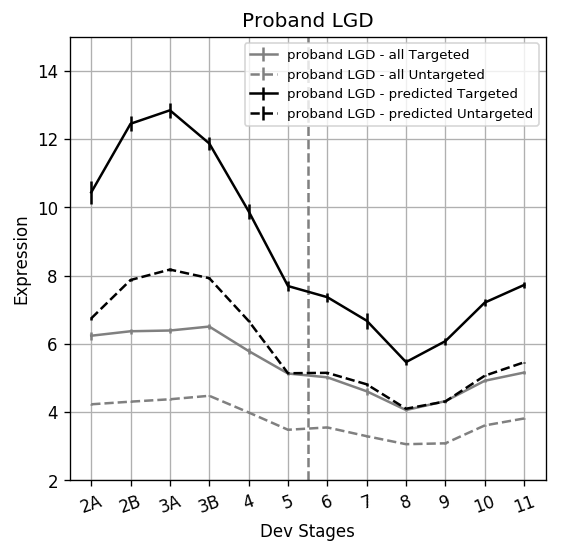

In [716]:
prolgd = probandLGD.Reduce(logscale=False)
prolgd1 = probandLGD1.Reduce(logscale=False)
fig, ax = plt.subplots(dpi=120)
plt.title("Proband LGD")
for title, color, Dat in [("proband LGD - all", 'grey', prolgd),("proband LGD - predicted", 'black', prolgd1)]:
    Tseq, Terr, Useq, Uerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post, bias = Bias(Tseq, Useq)
    print title, pre, post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.ylim(2,15)
plt.show()

In [717]:
TTseq, TTerr, UUseq, UUerr = probandLGD.Reduce(logscale=True)
N = 100 * 10
biases = []
for i in xrange(N):
    Tseq, Useq = [], []
    for (mu1, sig1, mu2, sig2) in zip(TTseq, TTerr, UUseq, UUerr):
        if np.isnan(mu1):
            continue
        s1 = np.random.normal(mu1, sig1)
        s2 = np.random.normal(mu2, sig2)
        Tseq.append(2**(s1))
        Useq.append(2**(s2))
    pre, post , bias= Bias(Tseq, Useq)
    biases.append(bias)
print np.mean(biases), math.sqrt(np.var(biases))

3.89721139351 0.24150077166


In [706]:
expdict1 = ins.LoadGeneSetDataFromFil("ProbandLGD.Regionsgt20.GeneExonLog2Exp.csv")

In [710]:
Genes = list(set(bp_exon_row_meta_with_gene["gene_symbol"].values))
probandLGD1 = GeneExonSet(expdict1)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    probandLGD1.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(probandLGD1.genes), len(probandLGD1.TargetedExon),len(probandLGD1.UntargetedExon)

94 118 2151


In [711]:
mpl.style.use('default')
for i in range(1):
    probandLGD.Reduce()
    probandLGD.Plot("Proband LGD")

RuntimeError: xdata and ydata must be the same length

# 2.1.1 Permute Proband LGD

In [222]:
T = []
for i in xrange(100000):
    bias = probandLGD.Permute()
    T.append(bias)

In [223]:
T_obs = 11.0335670848
T.sort()
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print (1-i)/100000

-1


0
1.09356047133 1.49080375929
1.30055614103e-11


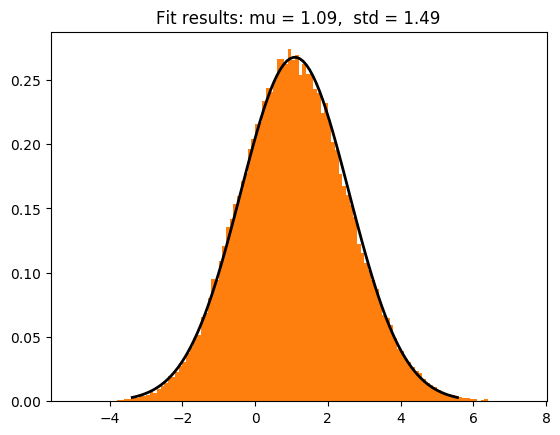

In [226]:
N=100000
from scipy.stats import norm
bins = [x*0.1 for x in range(-50, 75)]
plt.hist(T,bins=bins, normed=1)

T_obs = 11.0335670848
T.sort()
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print (N-i)/N

mu, std = norm.fit(T)
print mu, std
xmin, xmax = plt.xlim()
x = np.linspace(mu - 3*std, mu + 3*std, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
print norm.sf(T_obs, mu, std)
plt.show()

In [ ]:
syn_expdict = ins.LoadGeneSetDataFromFil("ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv")
proband_syn_Genes = list(set(bp_exon_row_meta_syn_with_gene["gene_symbol"].values))
probandSYN = GeneExonSet(syn_expdict)
for i, gene in enumerate(proband_syn_Genes):
    gene_df = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    probandSYN.addGene(gene, TargetedExon, UntargetedExon)

mis_expdict = ins.LoadGeneSetDataFromFil("ProbandMIS.Regionsgt20.GeneExonLog2Exp.csv")
proband_mis_Genes = list(set(bp_exon_row_meta_mis_with_gene["gene_symbol"].values))
probandMIS = GeneExonSet(mis_expdict)
for i, gene in enumerate(proband_mis_Genes):
    gene_df = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    probandMIS.addGene(gene, TargetedExon, UntargetedExon)
    
sibsyn_expdict = ins.LoadGeneSetDataFromFil("SiblingSYN.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"].values))
SiblingSYN = GeneExonSet(sibsyn_expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    SiblingSYN.addGene(gene, TargetedExon, UntargetedExon)

In [ ]:
Genes = list(set(bp_exon_row_meta_with_gene["gene_symbol"].values))
probandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    probandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(probandLGD.genes), len(probandLGD.TargetedExon),len(probandLGD.UntargetedExon)

In [ ]:
prosynDat = probandSYN.Reduce()
promisDat = probandMIS.Reduce()
sibsynDat = SiblingSYN.Reduce()
siblgdDat = SiblingLGD.Reduce()
fig, ax = plt.subplots(dpi=200)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat), ("proband mis", 'blue', promisDat), 
                          ("sibling syn", 'yellow', sibsynDat), ("sibling lgd", 'pink', siblgdDat)]:
    Tseq, Terr, Useq, Uerr = Dat
    ax.errorbar(range(2,15), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,15), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post = Bias(Tseq, Useq)
    print title, pre, post, pre-post
ax.grid(True)
ax.axvline(x=7.5, color="black")
plt.xticks(np.arange(2,15), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# 2.2 Proband SYN

In [113]:
SynVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014ProSYN.xlsx"
syn_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, SynVarFile, IntersectionWithPredicted=False)
bp_exon_row_meta_syn_with_gene = syn_annotated_exon_row_meta[syn_annotated_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_syn_with_gene.to_excel("GenesExonsTargetedBySYN.xlsx", index=False)
bp_exon_row_meta_syn_with_var = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["Vars"]!=""]
bp_exon_row_meta_syn_without_var = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["Vars"]==""]
print bp_exon_row_meta_syn_with_gene.shape, bp_exon_row_meta_syn_with_var.shape, bp_exon_row_meta_syn_without_var.shape

309222(12454, 15) (615, 15) (11839, 15)


In [114]:
Genes = list(set(bp_exon_row_meta_syn_with_gene["gene_symbol"].values))
ins.LoadGeneSetData2Fil("ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv", 
                        Genes, Regionsgt20, bp_exon_row_meta_syn_with_gene, bp_exon_col_meta, ExonExp)

Total Num of Genes: 593
Load 12 genes

In [149]:
syn_expdict = ins.LoadGeneSetDataFromFil("ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_syn_with_gene["gene_symbol"].values))
probandSYN = GeneExonSet(syn_expdict)
count0, count1, count2 = 0,0,0
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    count0 += 1
    count1 += len(TargetedExon)
    count2 += len(UntargetedExon)
    probandSYN.addGene(gene, TargetedExon, UntargetedExon)
print count0, count1, count2
print len(probandSYN.genes), len(probandSYN.TargetedExon),len(probandSYN.UntargetedExon)

593 615 11839
593 615 11839


# 2.3 Proband Mis

In [185]:
MisVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014ProMIS.xlsx"
mis_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, MisVarFile, IntersectionWithPredicted=False)
bp_exon_row_meta_mis_with_gene = mis_annotated_exon_row_meta[mis_annotated_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_mis_with_gene.to_excel("GenesExonsTargetedByMIS.xlsx", index=False)
bp_exon_row_meta_mis_with_var = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["Vars"]!=""]
bp_exon_row_meta_mis_without_var = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["Vars"]==""]
print bp_exon_row_meta_mis_with_gene.shape, bp_exon_row_meta_mis_with_var.shape, bp_exon_row_meta_mis_without_var.shape

309222(30127, 15) (1583, 15) (28544, 15)


In [186]:
Genes = list(set(bp_exon_row_meta_mis_with_gene["gene_symbol"].values))
ins.LoadGeneSetData2Fil("Probandmis.Regionsgt20.GeneExonLog2Exp.csv", 
                        Genes, Regionsgt20, bp_exon_row_meta_mis_with_gene, bp_exon_col_meta, ExonExp)

Total Num of Genes: 1436


# 2.4 Sibling SYN

In [678]:
SibNSYNVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014SibSYN.xlsx"
sibnsyn_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, SibNSYNVarFile, IntersectionWithPredicted=False)
bp_exon_row_meta_sibnsyn_with_gene = sibnsyn_annotated_exon_row_meta[sibnsyn_annotated_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_sibnsyn_with_gene.to_excel("GenesExonsTargetedBySibSYN.xlsx", index=False)
bp_exon_row_meta_sibnsyn_with_var = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["Vars"]!=""]
bp_exon_row_meta_sibnsyn_without_var = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["Vars"]==""]
print bp_exon_row_meta_sibnsyn_with_gene.shape, bp_exon_row_meta_sibnsyn_with_var.shape, bp_exon_row_meta_sibnsyn_without_var.shape

309222(8737, 16) (465, 16) (8272, 16)


In [680]:
bp_exon_row_meta_sibnsyn_with_gene.head()

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,NVIQ70,VIQ70,Gender,Func,Vars,GeneHited,Last
1420,1421.0,1086954.0,ENSG00000005339,CREBBP,1387.0,3775054.0,3779875.0,4821.0,2154.0,113,123,sM,Chromatin,16:3779789,T,F
1421,1422.0,1086954.0,ENSG00000005339,CREBBP,1387.0,3781192.0,3781474.0,282.0,282.0,,,,Chromatin,,T,F
1422,1423.0,1086954.0,ENSG00000005339,CREBBP,1387.0,3781776.0,3781938.0,162.0,162.0,,,,Chromatin,,T,F
1423,1424.0,1086954.0,ENSG00000005339,CREBBP,1387.0,3786036.0,3786204.0,168.0,168.0,,,,Chromatin,,T,F
1424,1425.0,1086954.0,ENSG00000005339,CREBBP,1387.0,3786650.0,3786816.0,166.0,166.0,,,,Chromatin,,T,F


In [188]:
Genes = list(set(bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"].values))
ins.LoadGeneSetData2Fil("SiblingSYN.Regionsgt20.GeneExonLog2Exp.csv", 
                        Genes, Regionsgt20, bp_exon_row_meta_sibnsyn_with_gene, bp_exon_col_meta, ExonExp)

Total Num of Genes: 452


# 2.5 Sibling LGD

In [189]:
SibLGDVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014SibLGD.xlsx"
siblgd_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, SibLGDVarFile, IntersectionWithPredicted=False)
bp_exon_row_meta_siblgd_with_gene = siblgd_annotated_exon_row_meta[siblgd_annotated_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_siblgd_with_gene.to_excel("GenesExonsTargetedBySibLGD.xlsx", index=False)
bp_exon_row_meta_siblgd_with_var = bp_exon_row_meta_siblgd_with_gene[bp_exon_row_meta_siblgd_with_gene["Vars"]!=""]
bp_exon_row_meta_siblgd_without_var = bp_exon_row_meta_siblgd_with_gene[bp_exon_row_meta_siblgd_with_gene["Vars"]==""]
print bp_exon_row_meta_siblgd_with_gene.shape, bp_exon_row_meta_siblgd_with_var.shape, bp_exon_row_meta_siblgd_without_var.shape

309222(3769, 15) (178, 15) (3591, 15)


In [190]:
Genes = list(set(bp_exon_row_meta_siblgd_with_gene["gene_symbol"].values))
ins.LoadGeneSetData2Fil("SiblingLGD.Regionsgt20.GeneExonLog2Exp.csv", 
                        Genes, Regionsgt20, bp_exon_row_meta_siblgd_with_gene, bp_exon_col_meta, ExonExp)

Total Num of Genes: 176


# 2.6 Plot control

In [726]:
syn_expdict = ins.LoadGeneSetDataFromFil("ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv")
proband_syn_Genes = list(set(bp_exon_row_meta_syn_with_gene["gene_symbol"].values))
probandSYN = GeneExonSet(syn_expdict)
for i, gene in enumerate(proband_syn_Genes):
    gene_df = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    probandSYN.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)

mis_expdict = ins.LoadGeneSetDataFromFil("ProbandMIS.Regionsgt20.GeneExonLog2Exp.csv")
proband_mis_Genes = list(set(bp_exon_row_meta_mis_with_gene["gene_symbol"].values))
probandMIS = GeneExonSet(mis_expdict)
for i, gene in enumerate(proband_mis_Genes):
    gene_df = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    probandMIS.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)
    
sibsyn_expdict = ins.LoadGeneSetDataFromFil("SiblingSYN.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"].values))
SiblingSYN = GeneExonSet(sibsyn_expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    SiblingSYN.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)
    
siblgd_expdict = ins.LoadGeneSetDataFromFil("SiblingLGD.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_siblgd_with_gene["gene_symbol"].values))
SiblingLGD = GeneExonSet(siblgd_expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_siblgd_with_gene[bp_exon_row_meta_siblgd_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    SiblingLGD.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)

proband syn 1.3101186023 1.30897965152 1.0008701058
proband mis 1.31266670414 1.2977574146 1.01148850268
sibling syn 1.21261694496 1.19461671557 1.01506778631
sibling lgd 1.44382817344 1.46441667759 0.985940815575


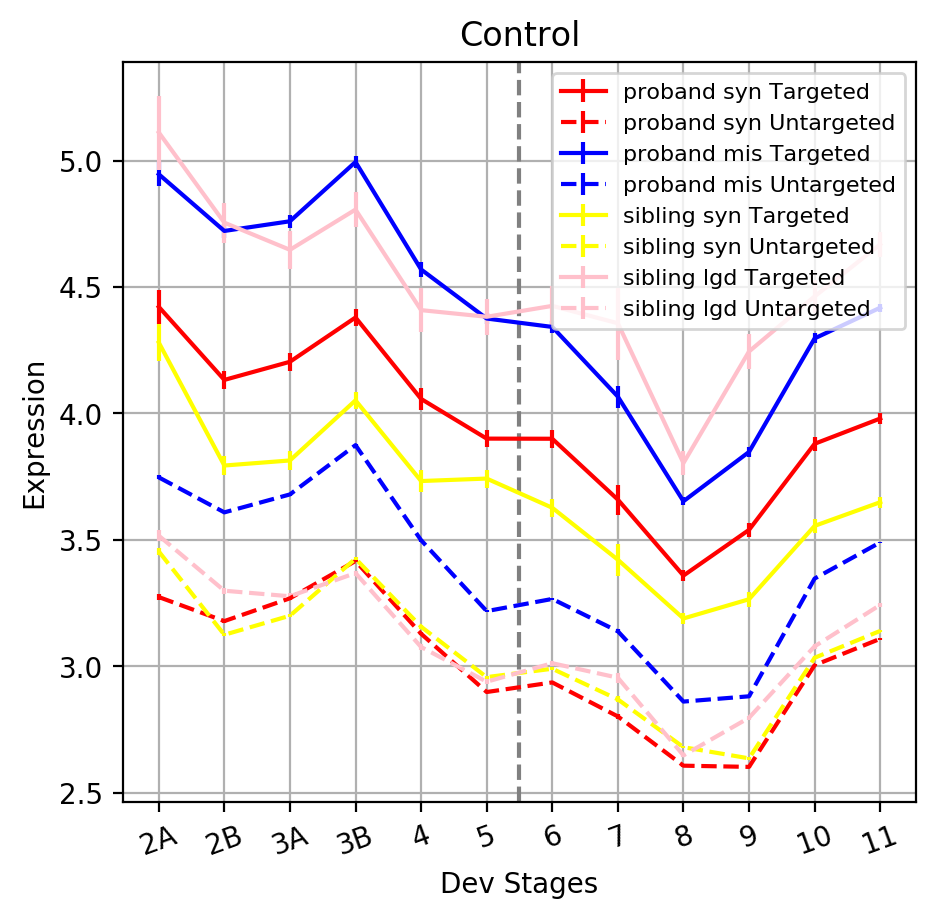

In [727]:
#prosynDat = probandSYN.Reduce(logscale = True)
#promisDat = probandMIS.Reduce(logscale = True)
#sibsynDat = SiblingSYN.Reduce(logscale = True)
#siblgdDat = SiblingLGD.Reduce(logscale = True)
prosynDat = probandSYN.Reduce()
promisDat = probandMIS.Reduce()
sibsynDat = SiblingSYN.Reduce()
siblgdDat = SiblingLGD.Reduce()
fig, ax = plt.subplots(dpi=200)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat), ("proband mis", 'blue', promisDat), 
                          ("sibling syn", 'yellow', sibsynDat), ("sibling lgd", 'pink', siblgdDat)]:
    Tseq, Terr, Useq, Uerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post, bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    print title, pre, post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
#plt.ylim(2, 15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()

proband syn 1.00105017834 1.00017991599 1.0008701058
proband mis 1.0060615363 0.99463467319 1.01148850268
sibling syn 1.00778917528 0.992829433537 1.01506778631
sibling lgd 0.993649004506 1.00781810511 0.985940815575


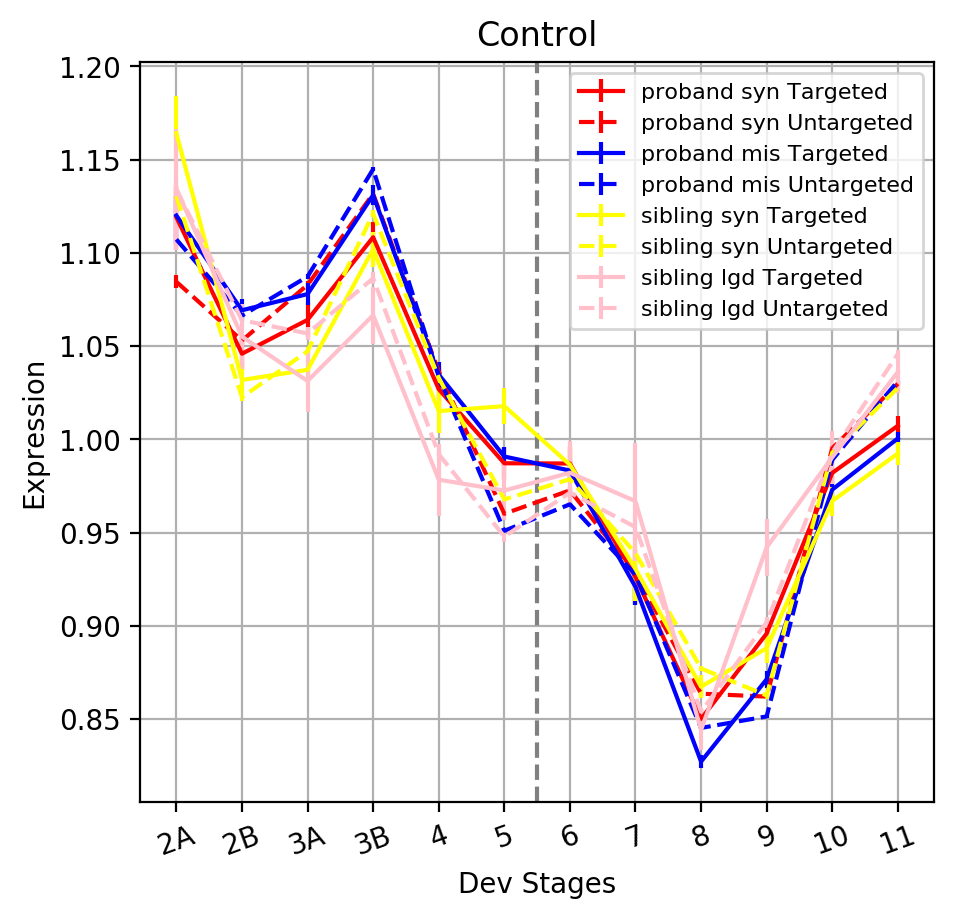

In [728]:
prosynDat = probandSYN.Reduce()
promisDat = probandMIS.Reduce()
sibsynDat = SiblingSYN.Reduce()
siblgdDat = SiblingLGD.Reduce()
fig, ax = plt.subplots(dpi=200)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat), ("proband mis", 'blue', promisDat), 
                          ("sibling syn", 'yellow', sibsynDat), ("sibling lgd", 'pink', siblgdDat)]:
    Tseq, Terr, Useq, Uerr = Dat
    Tseq_mean, Useq_mean = np.mean(Tseq), np.mean(Useq)
    Tseq = [x/Tseq_mean for x in Tseq]
    Useq = [x/Useq_mean for x in Useq]
    Terr = [x/Tseq_mean for x in Terr]
    Uerr = [x/Useq_mean for x in Uerr]
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post, bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    print title, pre, post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
#plt.ylim(2, 15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()

0.0152168929666 0.992391553517


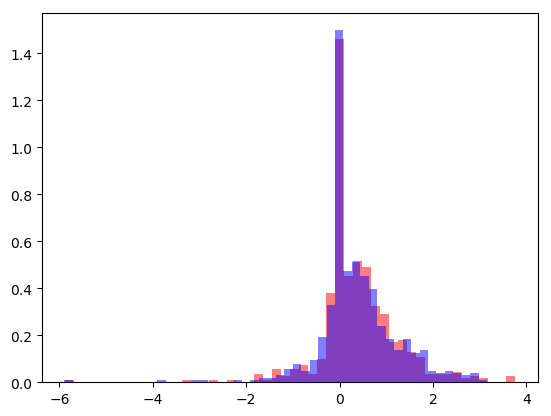

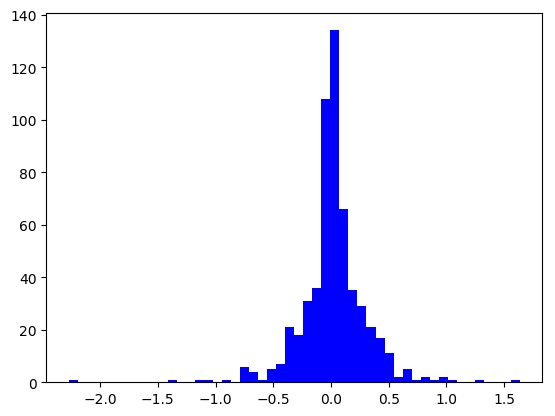

0.0187788715274


In [477]:
Pre, Post = probandSYN.wilcoxonTest()
diff = [(x-y) for x,y in zip(Pre, Post)]
diff = [x for x in diff if str(x) != 'nan']
pre = [x for x in Pre if str(x) != 'nan'] 
post = [x for x in Post if str(x) != 'nan'] 
from scipy.stats import wilcoxon
t, p = wilcoxon(pre, post)
print p, 1-p/2
bins = [x*0.1 for x in xrange(-50,50)]
plt.hist(pre, 50, color="red", normed=1, alpha=0.5)
plt.hist(post, 50, color="blue", normed=1, alpha=0.5)
plt.show()
bins = [x*0.1 for x in xrange(-20,20)]
plt.hist(diff, 50, color="blue")
plt.show()
print np.mean(diff)

1.26087819588e-08 0.999999993696


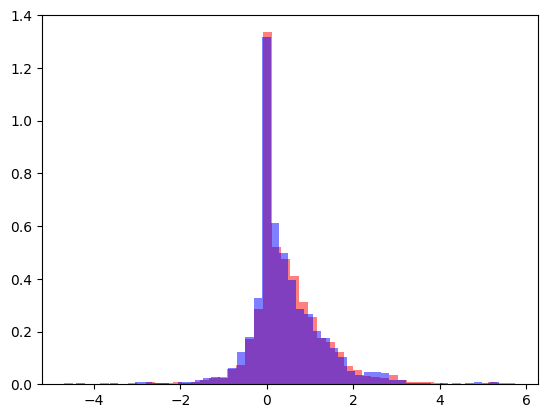

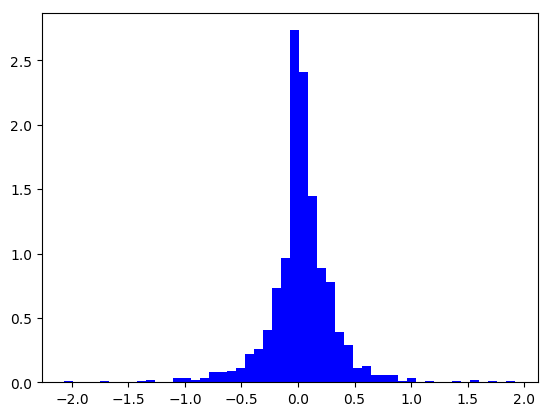

0.027088162095


In [478]:
Pre, Post = probandMIS.wilcoxonTest()
diff = [(x-y) for x,y in zip(Pre, Post)]
diff = [x for x in diff if str(x) != 'nan']
pre = [x for x in Pre if str(x) != 'nan'] 
post = [x for x in Post if str(x) != 'nan'] 
from scipy.stats import wilcoxon
t, p = wilcoxon(pre, post)
print p, 1-p/2
bins = [x*0.1 for x in xrange(-50,50)]
plt.hist(pre, 50, color="red", normed=1, alpha=0.5)
plt.hist(post, 50, color="blue", normed=1, alpha=0.5)
plt.show()
bins = [x*0.1 for x in xrange(-20,20)]
plt.hist(diff, 50, color="blue", normed=1)
plt.show()
print np.mean(diff)

0.000982149700566 0.99950892515


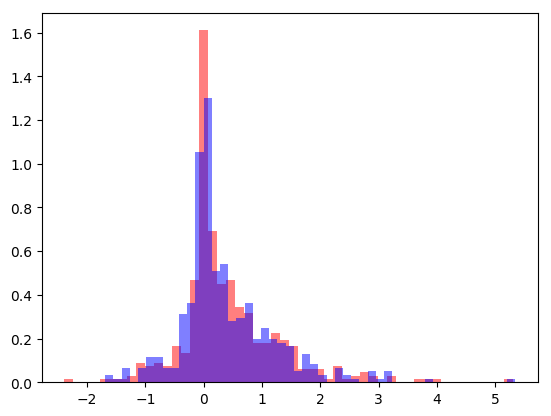

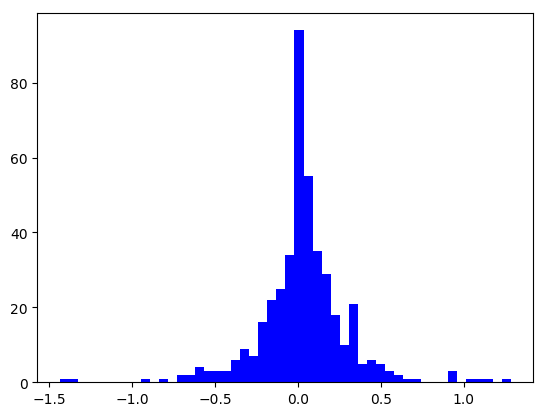

0.0312427638598


In [475]:
Pre, Post = SiblingSYN.wilcoxonTest()
diff = [(x-y) for x,y in zip(Pre, Post)]
diff = [x for x in diff if str(x) != 'nan']
pre = [x for x in Pre if str(x) != 'nan'] 
post = [x for x in Post if str(x) != 'nan'] 
from scipy.stats import wilcoxon
t, p = wilcoxon(pre, post)
print p, 1-p/2
bins = [x*0.1 for x in xrange(-50,50)]
plt.hist(pre, 50, color="red", normed=1, alpha=0.5)
plt.hist(post, 50, color="blue", normed=1, alpha=0.5)
plt.show()
bins = [x*0.1 for x in xrange(-20,20)]
plt.hist(diff, 50, color="blue")
plt.show()
print np.mean(diff)

0.886791595785 0.556604202107


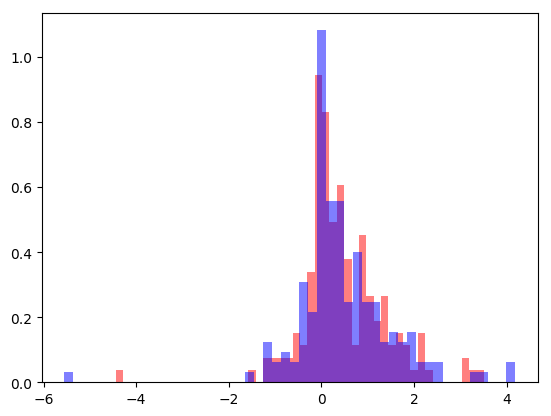

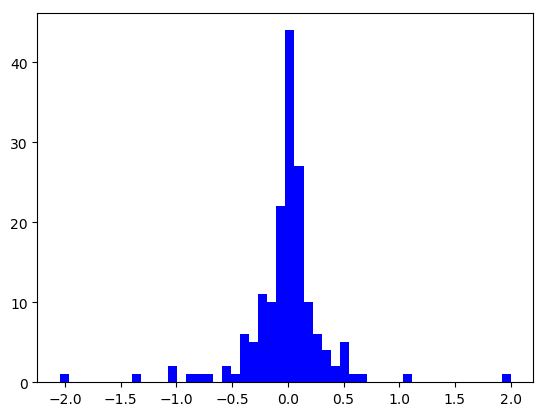

-0.0167268696248


In [474]:
Pre, Post = SiblingLGD.wilcoxonTest()
diff = [(x-y) for x,y in zip(Pre, Post)]
diff = [x for x in diff if str(x) != 'nan']
pre = [x for x in Pre if str(x) != 'nan'] 
post = [x for x in Post if str(x) != 'nan'] 
from scipy.stats import wilcoxon
t, p = wilcoxon(pre, post)
print p, 1-p/2
bins = [x*0.1 for x in xrange(-50,50)]
plt.hist(pre, 50, color="red", normed=1, alpha=0.5)
plt.hist(post, 50, color="blue", normed=1, alpha=0.5)
plt.show()
bins = [x*0.1 for x in xrange(-20,20)]
plt.hist(diff, 50, color="blue")
plt.show()
print np.mean(diff)

In [681]:
syn_expdict = ins.LoadGeneSetDataFromFil("ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv")
proband_syn_Genes = list(set(bp_exon_row_meta_syn_with_gene["gene_symbol"].values))
probandSYN = GeneExonSet(syn_expdict)
for i, gene in enumerate(proband_syn_Genes):
    gene_df = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    probandSYN.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)

KeyError: 'cds length'

In [ ]:
def lengthdis(SET1, SET2, dat):
    print len(SET1), len(SET2)
    list1 = dat[dat["row_num"].isin(SET1)]["exon length"].values
    list2 = dat[dat["row_num"].isin(SET2)]["exon length"].values
    bins = [x*0.1 for x in xrange(100)]
    plt.hist([math.log(x, 10) for x in list1], bins=bins, normed=1)
    plt.hist([math.log(x, 10) for x in list2 if x !=0], alpha = 0.2, bins=bins, normed=1)
    plt.xlim(0, 4.5)
    plt.show()
T = []
N = 100
for i in xrange(N):
    bias, TE, UE = probandSYN.Permute(plot=False)
    T.append(bias)
    #lengthdis(TE, UE, bp_exon_row_meta)

In [ ]:
T.sort()
#print T
T_obs = 0.67
#T_obs = 0.00752739009968
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
print T[-10:]
bins = [x*0.01 for x in range(-120, 50)]
plt.hist(T, 50)
plt.show()

In [534]:
N = 100
T = []
for i in xrange(N):
    bias, TE, UE = probandMIS.Permute(plot=False)
    T.append(bias)

[-0.52281408469697066, -0.52069100768375387, -0.5159022544742311, -0.50474608738694915, -0.47024398978918391, -0.45152889583222677, -0.42081078229420488, -0.41389401421077032, -0.36641364697436174, -0.33925257318248025]
1
0.01


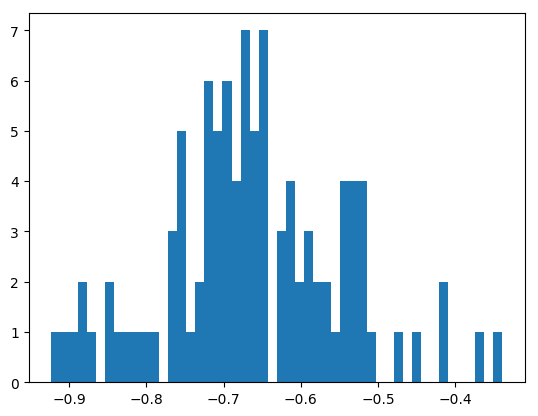

In [535]:
T_obs = 1.09
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[-0.32073105220198306, -0.29567564920988909, -0.28220828196549252, -0.27642061667060158, -0.25742885295879647, -0.24579237384820329, -0.21489981084521848, -0.19032069998827561, -0.042072881588004929, 0.0026750498144210155]
1
0.01


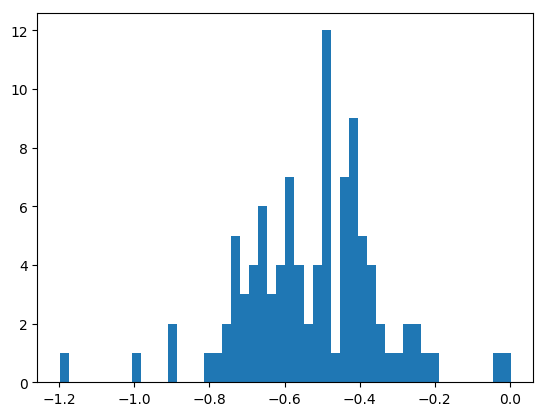

In [536]:
N = 100
T = []
for i in xrange(N):
    bias, TE, UE = SiblingSYN.Permute(plot=False)
    T.append(bias)
T_obs = 0.73
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [537]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = SiblingLGD.Permute(plot=False)
    T.append(bias)
T_obs = 0.404021835519
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

KeyboardInterrupt: 

In [645]:
test = probandSYN.genes[:]
print len(test)
random.shuffle(test)
test = test[:40]
syn_expdict = ins.LoadGeneSetDataFromFil("ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv")
probandSYN_test = GeneExonSet(syn_expdict)
for i, gene in enumerate(test):
    gene_df = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    probandSYN_test.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)

593


proband syn 7.79027132595 6.6160936404 1.17417768555


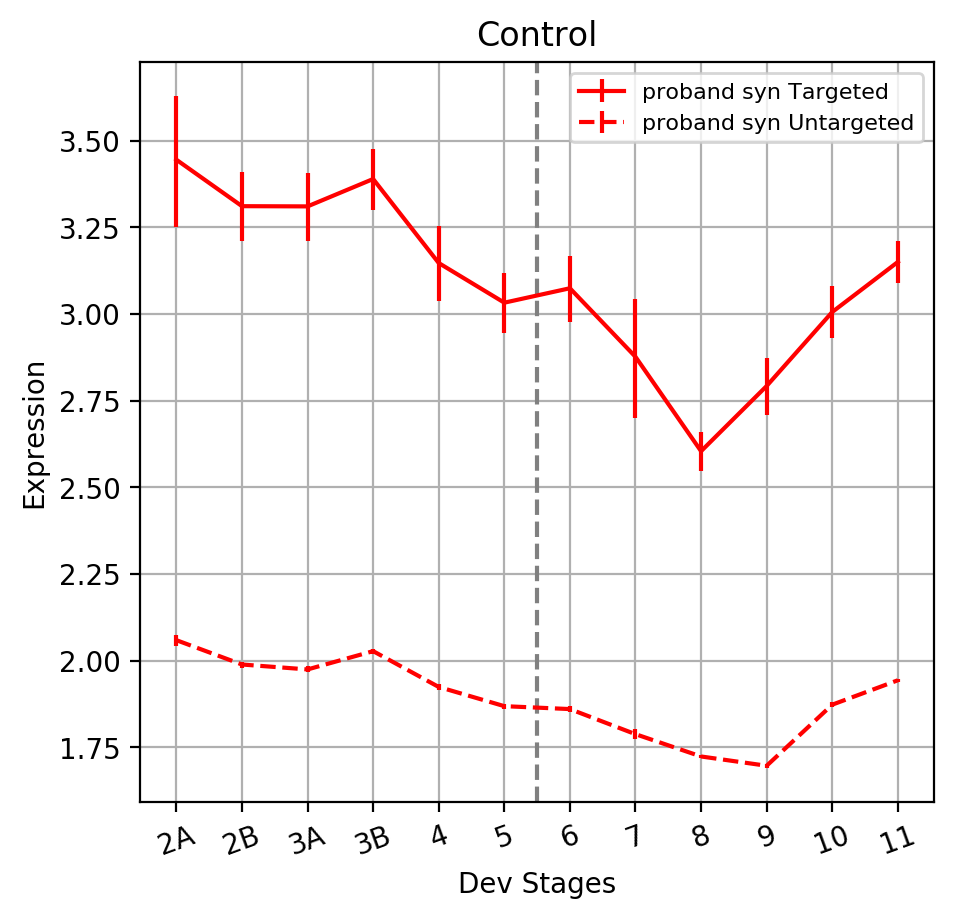

In [646]:
prosynDat = probandSYN_test.Reduce()
fig, ax = plt.subplots(dpi=200)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat)]:
    Tseq, Terr, Useq, Uerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post, O_bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    print title, pre, post, O_bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
#plt.ylim(2, 15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()

In [730]:
N = 100
T = []
for i in xrange(N):
    bias, TE, UE = probandSYN_test.Permute(plot=False)
    T.append(bias)
T_obs = O_bias
T_obs = 1.00087
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

KeyError: 'XPNPEP2'

593
proband syn 8.21079246882 6.41164569456 1.79914677426


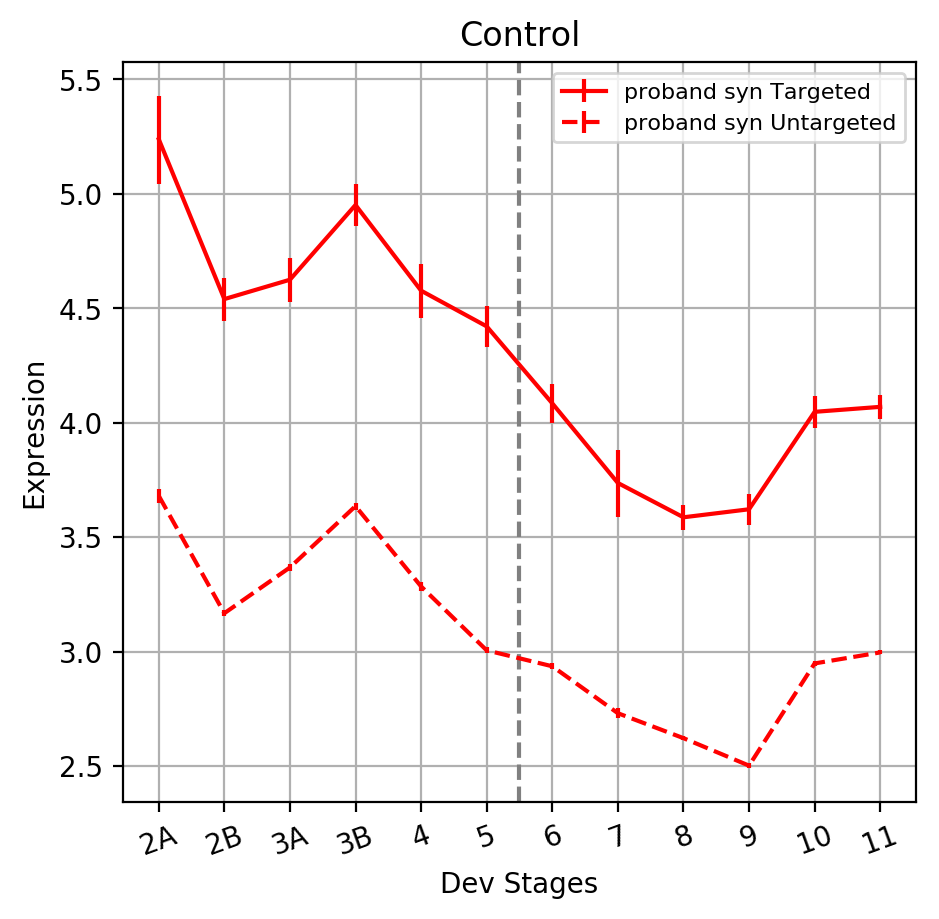

[0.25339243526916988, 0.27659322783892959, 0.41719210469500956, 0.47411403118853457, 0.57213215631516068, 0.58983843240525369, 0.60004974844258108, 0.72027388438671203, 0.78929397817228963, 1.1500012485492466]
1
0.01


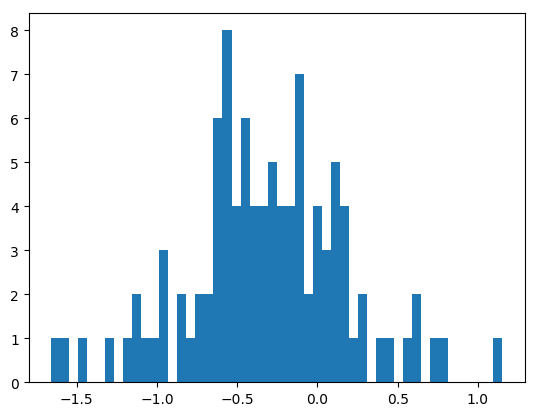

In [632]:
test = probandSYN.genes[:]
print len(test)
random.shuffle(test)
test = test[:100]
syn_expdict = ins.LoadGeneSetDataFromFil("ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv")
probandSYN_test = GeneExonSet(syn_expdict)
for i, gene in enumerate(test):
    gene_df = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    probandSYN_test.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)
prosynDat = probandSYN_test.Reduce()
fig, ax = plt.subplots(dpi=200)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat)]:
    Tseq, Terr, Useq, Uerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post, O_bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    print title, pre, post, O_bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
#plt.ylim(2, 15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()
N = 100
T = []
for i in xrange(N):
    bias, TE, UE = probandSYN_test.Permute(plot=False)
    T.append(bias)
T_obs = O_bias
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [580]:
biases = []
syn_expdict = ins.LoadGeneSetDataFromFil("ProbandSYN.Regionsgt20.GeneExonLog2Exp.csv")

for i in range(10):
    test = probandSYN.genes[:]
    random.shuffle(test)
    test = test[:20]
    probandSYN_test = GeneExonSet(syn_expdict)
    for i, gene in enumerate(test):
        gene_df = bp_exon_row_meta_syn_with_gene[bp_exon_row_meta_syn_with_gene["gene_symbol"]==gene]
        TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
        UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
        TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
        UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
        probandSYN_test.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)  

    Tseq, Terr, Useq, Uerr = probandSYN_test.Reduce()
    pre, post, bias = Bias(Tseq, Useq)
    biases.append(bias)
        

[5.3222785054723145, 0.21540957313169962, 6.6912781383214313, 1.7628729110618133, 2.0813705501645732, -3.7344953110376391, -0.40684228143578416, 0.4736227764866765, -0.86820504392052067, -0.48229443570004227]


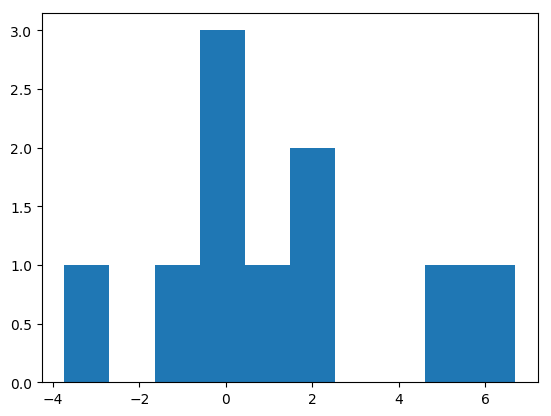

In [581]:
print biases
plt.hist(biases)
plt.show()

[0.46489775249943666, 0.47470250583771634, 0.50069019507578405, 0.50302123060839676, 0.51339777640406981, 0.57074073516391532, 0.61150384850499551, 0.61662938240688225, 0.66176493827392324, 0.90659649042173385]
999
1
0.001


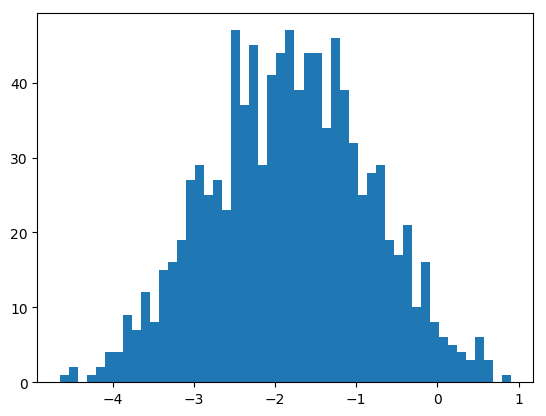

In [572]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = probandSYN_test.Permute(plot=False)
    T.append(bias)
T_obs = 0.73
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [545]:
TTseq, TTerr, UUseq, UUerr = probandSYN.Reduce(logscale=True)
N = 100 * 100
biases = []
for i in xrange(N):
    Tseq, Useq = [], []
    for (mu1, sig1, mu2, sig2) in zip(TTseq, TTerr, UUseq, UUerr):
        if np.isnan(mu1):
            continue
        s1 = np.random.normal(mu1, sig1)
        s2 = np.random.normal(mu2, sig2)
        Tseq.append(2**(s1))
        Useq.append(2**(s2))
    pre, post , bias= Bias(Tseq, Useq)
    biases.append(bias)
print np.mean(biases), math.sqrt(np.var(biases))

0.67459586563 0.136604299713


In [544]:
TTseq, TTerr, UUseq, UUerr = probandMIS.Reduce(logscale=True)
N = 100 * 100
biases = []
for i in xrange(N):
    Tseq, Useq = [], []
    for (mu1, sig1, mu2, sig2) in zip(TTseq, TTerr, UUseq, UUerr):
        if np.isnan(mu1):
            continue
        s1 = np.random.normal(mu1, sig1)
        s2 = np.random.normal(mu2, sig2)
        Tseq.append(2**(s1))
        Useq.append(2**(s2))
    pre, post , bias= Bias(Tseq, Useq)
    biases.append(bias)
print np.mean(biases), math.sqrt(np.var(biases))

1.09953835518 0.0979600856734


In [542]:
TTseq, TTerr, UUseq, UUerr = SiblingSYN.Reduce(logscale=True)
N = 100 * 10
biases = []
for i in xrange(N):
    Tseq, Useq = [], []
    for (mu1, sig1, mu2, sig2) in zip(TTseq, TTerr, UUseq, UUerr):
        if np.isnan(mu1):
            continue
        s1 = np.random.normal(mu1, sig1)
        s2 = np.random.normal(mu2, sig2)
        Tseq.append(2**(s1))
        Useq.append(2**(s2))
    pre, post , bias= Bias(Tseq, Useq)
    biases.append(bias)
print np.mean(biases), math.sqrt(np.var(biases))

0.743786638274 0.138553277242


In [546]:
TTseq, TTerr, UUseq, UUerr = SiblingLGD.Reduce(logscale=True)
N = 100 * 100
biases = []
for i in xrange(N):
    Tseq, Useq = [], []
    for (mu1, sig1, mu2, sig2) in zip(TTseq, TTerr, UUseq, UUerr):
        if np.isnan(mu1):
            continue
        s1 = np.random.normal(mu1, sig1)
        s2 = np.random.normal(mu2, sig2)
        Tseq.append(2**(s1))
        Useq.append(2**(s2))
    pre, post , bias= Bias(Tseq, Useq)
    biases.append(bias)
print np.mean(biases), math.sqrt(np.var(biases))

0.402191409587 0.307945119929


In [718]:
sibsyn_expdict = ins.LoadGeneSetDataFromFil("SiblingSYN.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"].values))
SiblingSYN = GeneExonSet(sibsyn_expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    SiblingSYN.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)

proband syn 4.09625803889 3.35719466505 0.739063373838


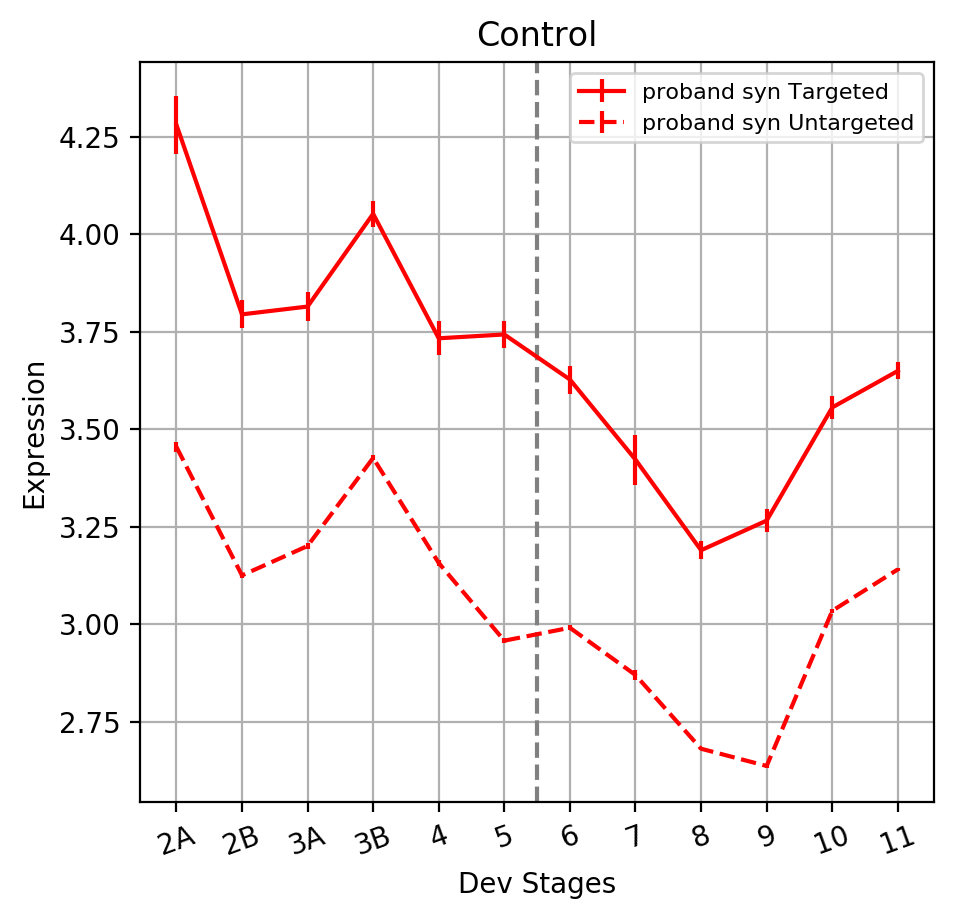

In [719]:
prosynDat = SiblingSYN.Reduce()
fig, ax = plt.subplots(dpi=200)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat)]:
    Tseq, Terr, Useq, Uerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post, O_bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    print title, pre, post, O_bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
#plt.ylim(2, 15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()

[1.0147979264389908, 1.0152781868521887, 1.0153971239506163, 1.0160041246514193, 1.0165072769303238, 1.0174103913703669, 1.0188152897885288, 1.0196146139638844, 1.0198612083824143, 1.0239589238183575]
991
9
0.009


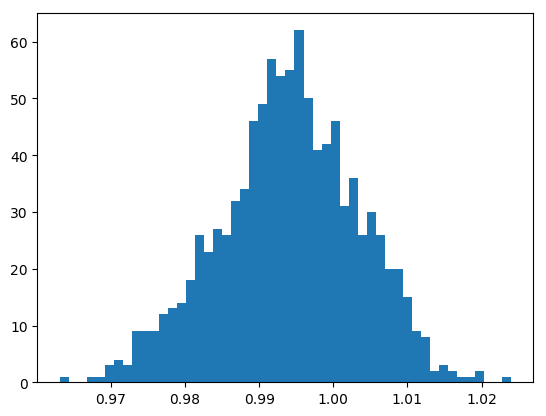

In [732]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = SiblingSYN.Permute(plot=False)
    T.append(bias)
T_obs = O_bias
T_obs = 1.015
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [723]:
test = SiblingSYN.genes[:]
print len(test)
random.shuffle(test)
test = test[:20]
print test
syn_expdict = ins.LoadGeneSetDataFromFil("SiblingSYN.Regionsgt20.GeneExonLog2Exp.csv")
SYN_test = GeneExonSet(syn_expdict)
for i, gene in enumerate(test):
    gene_df = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    probandSYN_test.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)
prosynDat = SYN_test.Reduce()
fig, ax = plt.subplots(dpi=200)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat)]:
    Tseq, Terr, Useq, Uerr = Dat
    #ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    #ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post, O_bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    #print title, pre, post, O_bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='upper right', fontsize=8)
#plt.ylim(2, 15)
#plt.xlabel("Dev Stages")
#plt.ylabel("Expression")
#plt.show()

N = 100
T = []
for i in xrange(N):
    bias, TE, UE = probandSYN_test.Permute(plot=False)
    T.append(bias)
T_obs = O_bias
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

452
['IREB2', 'SHANK2', 'PPP1R26', 'ATP1B4', 'FKBP15', 'PPP1R12B', 'CREBBP', 'ALDH18A1', 'KRT39', 'USP35', 'RNF216', 'LILRB2', 'MTERF', 'GUSB', 'VWDE', 'GET4', 'NOB1', 'MED16', 'MYO6', 'DDR1']


KeyError: 'XPNPEP2'

In [686]:
JonExons = open("/Users/jiayao/Work/BrainDisorders/data/rows.txt", 'rb')
Dat = {}
for x in range(8):
    name = JonExons.readline().strip()
    exonids = set(map(int, JonExons.readline().strip().split()))
    Dat[name] = exonids

In [236]:
print Dat.keys()

['SIB.LGD.MUT', 'SIB.LGD.NOT', 'SIB.SYN.NOT', 'PROB.MIS.MUT', 'PROB.SYN.NOT', 'PROB.SYN.MUT', 'PROB.MIS.NOT', 'SIB.SYN.MUT']
